# Classification of Chest X-Rays (Pneumonia vs. Healthy)
## Pneumonia Background
- Pneumonia causes alveoli (air sacs in the lungs) to fill with fluid or pus
- Cause: bacterial, viral, or fungal infection
- Symptoms: cough with or without mucus, fever, chills, and trouble breathing
    - severity depends on age and overall health of the individual 
- Diagnosis: physical exam and chest X-ray imaging
    - Radiologists look for infiltrates (white spots) in the lungs for signs of infection
    - Lung inflammation is visualized by having denser, more opaque areas in imaging

- Sources: 
    - 1) https://www.nhlbi.nih.gov/health/pneumonia
    - 2) https://www.mayoclinic.org/diseases-conditions/pneumonia/multimedia/chest-x-ray-showing-pneumonia/img-20005827

## Assignment
- Classify chest X-ray images as either healthy (normal) or having pneumonia
- Use CNN models to classify image data

In [1]:
# extract all files from zipfile to 'directory to extract 2'
#import zipfile as zf
#files = zf.ZipFile("chest_xray.zip", 'r')
#files.extractall('directory to extract 2')
#files.close()

In [2]:
import os
import numpy as np
import shutil
import random
import glob 

import pandas as pd
import pathlib
import seaborn as sns
import requests
from sklearn.metrics import confusion_matrix

import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import datasets, layers, models
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPool2D, Dropout
from keras.callbacks import ReduceLROnPlateau
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from PIL import Image
from PIL.ExifTags import TAGS

### Commenting out the code below because it was only needed once to split the image files accordingly

In [3]:
pip show tensorflow

Name: tensorflow
Version: 2.6.0
Summary: TensorFlow is an open source machine learning framework for everyone.
Home-page: https://www.tensorflow.org/
Author: Google Inc.
Author-email: packages@tensorflow.org
License: Apache 2.0
Location: /opt/anaconda3/lib/python3.7/site-packages
Requires: clang, keras-preprocessing, astunparse, flatbuffers, google-pasta, termcolor, tensorboard, h5py, wrapt, absl-py, opt-einsum, gast, typing-extensions, protobuf, keras, grpcio, wheel, numpy, six, tensorflow-estimator
Required-by: 
Note: you may need to restart the kernel to use updated packages.


In [4]:
# splitting the NORMAL dataset into train/test for modeling

#root_dir = '/Users/seetarajpara/Desktop/chest_xray/'
#classes_dir = ['NORMAL']

#test_ratio = 0.20

#for cls in classes_dir:
    #os.makedirs(root_dir +'train/' + cls)
    #os.makedirs(root_dir +'test/' + cls)

# Creating partitions of the data after shuffling
#src = root_dir + cls

#allFileNames = os.listdir(src)
#np.random.shuffle(allFileNames)

#train_FileNames, test_FileNames = np.split(np.array(allFileNames), [int(len(allFileNames)* (1 - test_ratio))])

#train_FileNames = [src+'/'+ name for name in train_FileNames.tolist()]
#test_FileNames = [src+'/' + name for name in test_FileNames.tolist()]

#print('Total images: ', len(allFileNames))
#print('Training: ', len(train_FileNames))
#print('Testing: ', len(test_FileNames))

In [5]:
#for cls in classes_dir:
    #for name in train_FileNames:
        #shutil.copy(name, root_dir +'train/' + cls)
    
    #for name in test_FileNames:
        #shutil.copy(name, root_dir +'test/' + cls)

In [6]:
##### splitting the PNEUMONIA dataset into train/test for modeling

#root_dir = '/Users/seetarajpara/Desktop/chest_xray/'
#classes_dir = ['PNEUMONIA']

#test_ratio = 0.20

#for cls in classes_dir:
    #os.makedirs(root_dir +'train/' + cls)
    #os.makedirs(root_dir +'test/' + cls)

# Creating partitions of the data after shuffling
#src = root_dir + cls

#allFileNames = os.listdir(src)
#np.random.shuffle(allFileNames)

#train_FileNames, test_FileNames = np.split(np.array(allFileNames), [int(len(allFileNames)* (1 - test_ratio))])

#train_FileNames = [src+'/'+ name for name in train_FileNames.tolist()]
#test_FileNames = [src+'/' + name for name in test_FileNames.tolist()]

#print('Total images: ', len(allFileNames))
#print('Training: ', len(train_FileNames))
#print('Testing: ', len(test_FileNames))

In [7]:
#for cls in classes_dir:
    #for name in train_FileNames:
        #shutil.copy(name, root_dir +'train/' + cls)
    
    #for name in test_FileNames:
        #shutil.copy(name, root_dir +'test/' + cls)

## Inspect Datasets in Each Folder

In [8]:
training_data_path = pathlib.Path("/Users/seetarajpara/Desktop/chest_xray/train/")
testing_data_path = pathlib.Path("/Users/seetarajpara/Desktop/chest_xray/test/")

In [9]:
training_normal = glob.glob("/Users/seetarajpara/Desktop/chest_xray/train/NORMAL/*.jpeg")
training_pneumonia = glob.glob("/Users/seetarajpara/Desktop/chest_xray/train/PNEUMONIA/*.jpeg")
testing_normal = glob.glob("/Users/seetarajpara/Desktop/chest_xray/test/NORMAL/*.jpeg")
testing_pneumonia = glob.glob("/Users/seetarajpara/Desktop/chest_xray/test/PNEUMONIA/*.jpeg")

Text(0.5, 1.0, 'Number of Normal vs. Pneumonia Images in Training Dataset')

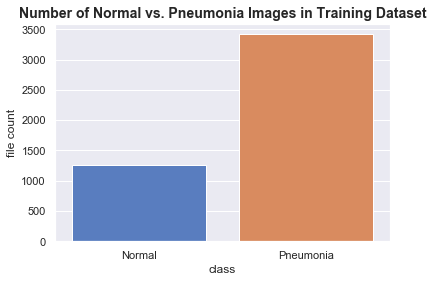

In [10]:
sns.set(style='darkgrid', palette='muted')
sns.barplot(x=["Normal","Pneumonia"],y=[len(training_normal),len(training_pneumonia)])
plt.ylabel('file count')
plt.xlabel('class')
plt.title('Number of Normal vs. Pneumonia Images in Training Dataset', fontsize=14, fontweight='bold')

Text(0.5, 1.0, 'Number of Normal vs. Pneumonia Images in Testing Dataset')

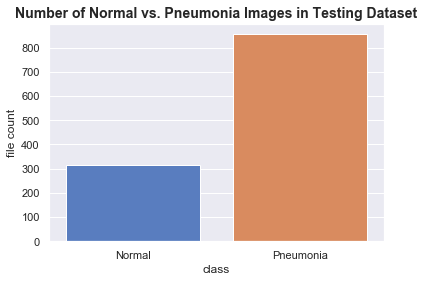

In [11]:
sns.set(style='darkgrid', palette='muted')
sns.barplot(x=["Normal","Pneumonia"],y=[len(testing_normal),len(testing_pneumonia)])
plt.ylabel('file count')
plt.xlabel('class')
plt.title('Number of Normal vs. Pneumonia Images in Testing Dataset', fontsize=14, fontweight='bold')

## Imbalanced Data
- We might have an issue with imbalanced data since we have about 70% pneumonia and 30% normal images to make our classification model (according to the previously shown barplots).
- This imbalance can lead to miscalls in classification so we might need to explore methods in data augmentation to enhance the model's learning ability to classify chest x-ray images as either normal or pneumonia.
- Will revisit this problem when building the CNN model.

## Exploratory Analysis
- Visualize some images to see what they look like.

In [12]:
# function to view a random image
def view_image(target_path, target_class):
    
    target_folder = target_path + "/" + target_class
    
    # print image label
    random_image = random.sample(os.listdir(target_folder),1)
    print(random_image)
    
    # show image
    image = mpimg.imread(target_folder+"/"+ random_image[0])
    plt.imshow(image)
    plt.title(target_class)
    plt.show()
    
    return image

['NORMAL2-IM-0340-0001.jpeg']


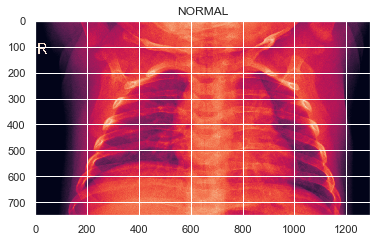

['person544_virus_1078.jpeg']


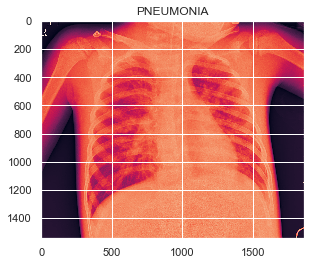

In [13]:
dir_path = "/Users/seetarajpara/Desktop/chest_xray/train/"

# view normal lung image
img = view_image(dir_path, "NORMAL")

# view pneumonia lung image
img = view_image(dir_path, "PNEUMONIA")

- Lung images show difference in X-ray opacity in patients with pneumonia
- Sizes are different, will need to re-size to default and allow crop aspect ratio

## Preprocessing
- Neural networks don't process raw data and need to vectorize & standardize images from each directory
- Original images exist as RGB coefficients in the 0-255 range; such values would be too high for our models to process, so we target values between 0 and 1 instead by scaling with a 1/255 factor.
- `tf.keras.preprocessing.image_dataset_from_directory()` turns images sorted into class-specific folders into a labeled dataset of image tensors

- Parameters:
    - `labels`: "inferred" labels are generated from the directory structure
    - `image_size`: Size to resize images to after they are read from disk. Defaults to (256, 256). 
    - `label_mode`: 'binary' means that the labels (there can be only 2) are encoded as float32 scalars with values 0 or 1 (e.g. for binary_crossentropy)
    - `crop_to_aspect_ratio`: If True, resize the images without aspect ratio distortion.

In [14]:
# preprocess images from each directory
# this is the augmentation configuration we will use for training
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1.0/255.0,
                                                                 rotation_range=0.2,
                                                                 zoom_range=0.2, 
                                                                 horizontal_flip=True, 
                                                                 vertical_flip=True)

# this is a generator that will read pictures found in train path, 
# and indefinitely generate batches of augmented image data
train_generator = tf.keras.preprocessing.image_dataset_from_directory(training_data_path,
                                                                shuffle=True, 
                                                                labels = 'inferred',
                                                                label_mode='binary', 
                                                                crop_to_aspect_ratio = True)

# this is the augmentation configuration we will use for testing:
# only rescaling
test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1.0/255.0)

# this is a similar generator, for validation data
test_generator = tf.keras.preprocessing.image_dataset_from_directory(testing_data_path,
                                                                labels = 'inferred',
                                                                label_mode='binary', 
                                                                crop_to_aspect_ratio = True)

Found 4684 files belonging to 2 classes.
Found 1172 files belonging to 2 classes.


## Prefetching 
- Overlaps the preprocessing and model execution of a training step. 
- While the model is executing training step 's', the input pipeline is reading the data for step 's+1'. 
- Doing so reduces the step time to the maximum (as opposed to the sum) of the training and the time it takes to extract the data.
- Source: https://www.tensorflow.org/guide/data_performance

"The tf.data API provides the `tf.data.Dataset.prefetch` transformation. It can be used to decouple the time when data is produced from the time when data is consumed. In particular, the transformation uses a background thread and an internal buffer to prefetch elements from the input dataset ahead of the time they are requested. The number of elements to prefetch should be equal to (or possibly greater than) the number of batches consumed by a single training step. You could either manually tune this value, or set it to `tf.data.AUTOTUNE`, which will prompt the `tf.data` runtime to tune the value dynamically at runtime."

In [15]:
train = train_generator.prefetch(tf.data.AUTOTUNE)
test = test_generator.prefetch(tf.data.AUTOTUNE)

In [16]:
print(train)

<PrefetchDataset shapes: ((None, 256, 256, 3), (None, 1)), types: (tf.float32, tf.float32)>


## Building a Convolutional Neural Network for Image Classification

### Sequential Model
- A sequential model is appropriate for a plain stack of layers where each layer has exactly one input tensor and one output tensor
- This model acts like a list of layers
- Building simple stack of 3 convolution layers with a ReLU activation and followed by max-pooling layers

### Dropout and Data Augmentation
- Data augmentation can mitigate overfitting, since we have this imbalanced dataset with fewer 'Normal' images, but the samples will still be highly correlated
- Focus on entropic capacity (how much info the model can store) of the model; this helps optimize the ideal amount of info to focus on to generate the most accurate calls.
    - Optimize the number of parameters in the model; number of layers and size of each layer
    - Weight regularization, forcing model weights to take in smaller values
- Dropout helps reduce overfitting because it prevents layers from seeing the same exact pattern twice
    - This will disrupt random correlations from occuring during the data processing/modeling steps
    - Randomly selecting nodes to be dropped-out with a given probability (50%) each weight update cycle

### Layer Activation Functions
- Activation function responsible for transforming the summed weighted input from the node into the activation of the node or output for that input
    - Rectified linear activation function (relu) is a piecewise linear function 
    - Output the input directly if it is positive, otherwise, it will output zero 
    - Default activation function for many types of neural networks
    - Easier to train and often achieves better performance

### Compile the Model
- Loss: Binary cross entropy compares each of the predicted probabilities to actual class output which can be either 0 or 1. It then calculates the score that penalizes the probabilities based on the distance from the expected value.
     - That means how close or far from the actual value.
- Optimizer: using Adam optimizer as it scored highest in learning rate (see Source 5)
- Metrics: accuracy to compare against validation dataset

### Sources: 
    1) https://machinelearningmastery.com/rectified-linear-activation-function-for-deep-learning-neural-networks/
    2) https://www.analyticsvidhya.com/blog/2020/10/create-image-classification-model-python-keras/
    3) https://keras.io/api/layers/activations/
    4) https://keras.io/examples/vision/image_classification_from_scratch/
    5) https://www.mdpi.com/2313-433X/6/9/92

In [17]:
# baseline model

# the model outputs 3D feature maps (height, width, features)
model_0 = Sequential()
model_0.add(Conv2D(32, (3, 3), input_shape=(256, 256, 3)))
model_0.add(Activation('relu'))
model_0.add(MaxPooling2D(pool_size=(2, 2)))

# 2nd layer
model_0.add(Conv2D(64, (3, 3)))
model_0.add(Activation('relu'))
model_0.add(MaxPooling2D(pool_size=(2, 2)))

# 3rd layer
model_0.add(Conv2D(128, (3, 3)))
model_0.add(Activation('relu'))
model_0.add(MaxPooling2D(pool_size=(2, 2)))

# this converts the 3D feature maps to 1D feature vectors
model_0.add(Flatten())  
model_0.add(Dense(128))
model_0.add(Activation('relu'))
model_0.add(Dropout(0.5))
model_0.add(Dense(1))
model_0.add(Activation('sigmoid'))

# stop training when a monitored metric has stopped improving.
# goal of a training is to maximize accuracy (monitor)
# patience: # of epochs with no improvement after which training will be stopped (2)
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', 
                                                  mode= 'max', 
                                                  restore_best_weights=True, 
                                                  patience=2)

# compile the model
opt = tf.keras.optimizers.Adam(learning_rate= 0.001)
model_0.compile(loss='binary_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

# get the summary
model_0.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 254, 254, 32)      896       
_________________________________________________________________
activation (Activation)      (None, 254, 254, 32)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 127, 127, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 125, 125, 64)      18496     
_________________________________________________________________
activation_1 (Activation)    (None, 125, 125, 64)      0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 62, 62, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 60, 60, 128)       7

In [18]:
# fit the model
history_model_0 = model_0.fit(train, epochs=5, validation_data=test, callbacks=early_stopping)

Epoch 1/5
147/147 [==============================] - 290s 2s/step - loss: 19.6788 - accuracy: 0.7419 - val_loss: 0.3194 - val_accuracy: 0.9044
Epoch 2/5
147/147 [==============================] - 286s 2s/step - loss: 0.5321 - accuracy: 0.7630 - val_loss: 0.3489 - val_accuracy: 0.7756
Epoch 3/5
147/147 [==============================] - 312s 2s/step - loss: 0.4583 - accuracy: 0.7854 - val_loss: 0.2771 - val_accuracy: 0.9104
Epoch 4/5
147/147 [==============================] - 310s 2s/step - loss: 0.3872 - accuracy: 0.8140 - val_loss: 0.2058 - val_accuracy: 0.9292
Epoch 5/5
147/147 [==============================] - 315s 2s/step - loss: 0.3490 - accuracy: 0.8266 - val_loss: 0.1990 - val_accuracy: 0.9164


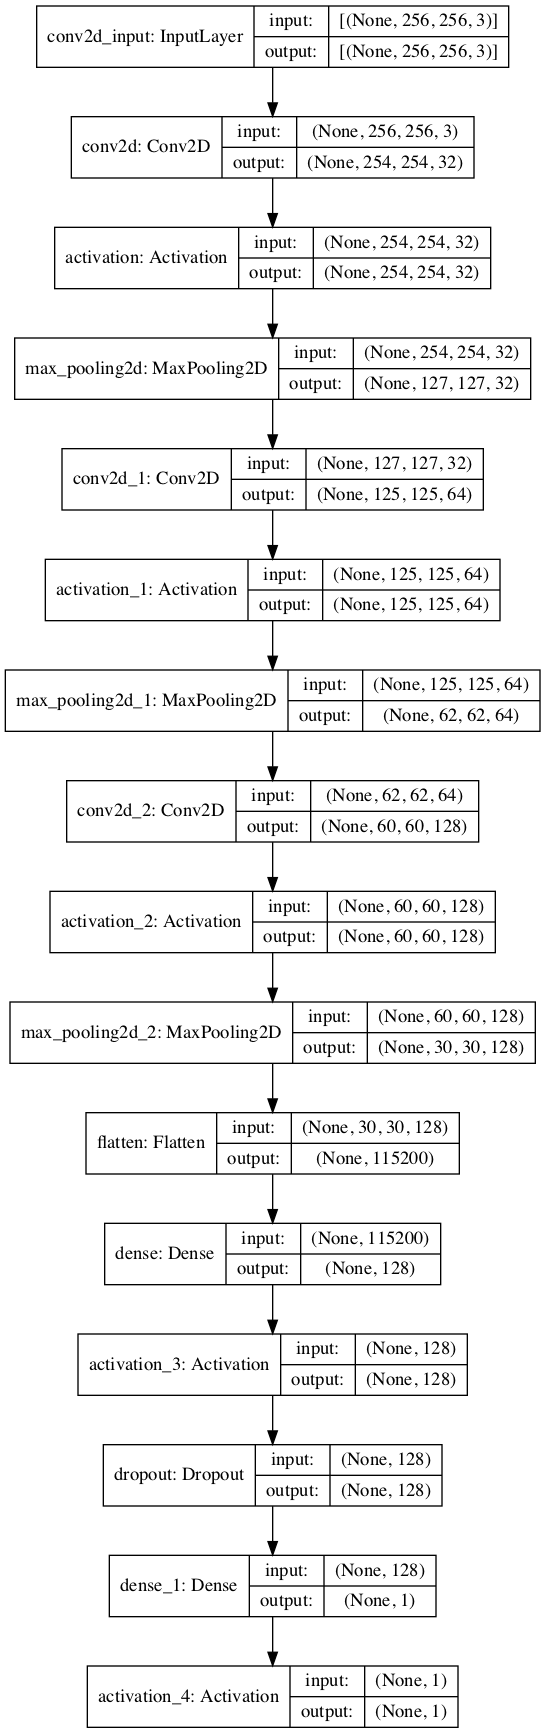

In [33]:
plot_model(model_0, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [19]:
def plot_model_results(model):
    
    accuracy = model.history['accuracy']
    loss = model.history['loss']
    
    val_accuracy = model.history['val_accuracy']
    val_loss = model.history['val_loss']
    
    epochs = range(1, len(accuracy) + 1)

    plt.plot(epochs, accuracy, label='Training Accuracy')
    plt.plot(epochs, val_accuracy, label='Validation Accuracy')
    plt.title('Model Accuracy')
    
    plt.ylabel('% accuracy')
    plt.xlabel('Epoch')
    plt.ylim(0.1, 1.0)
    plt.legend()
    plt.figure()

    plt.plot(epochs, loss, label='Training Loss')
    plt.plot(epochs, val_loss, label='Validation Loss')
    plt.title('Model Loss')
    
    plt.ylabel('% loss')
    plt.xlabel('Epoch')
    plt.ylim(0.1, 1.0)
    plt.legend()
    plt.show()

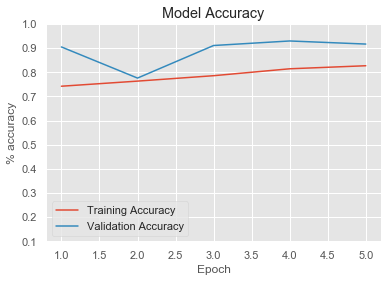

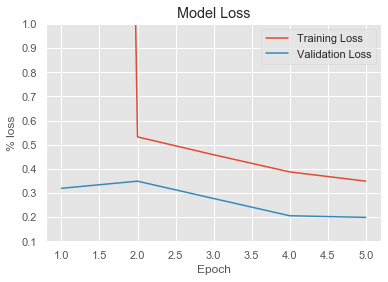

In [20]:
plt.style.use('ggplot')
plot_model_results(history_model_0)

## `model_0` Results
- We get 91% accuracy on our test dataset after the 5th epoch, which is great for the baseline.
- Could have gotten higher accuracy on training dataset (88-89%) but still, these are great for the first model
- We do have considerable loss, and it seems to increase for the validation dataset with each epoch. This could be something we try to minimize in the next model, as well. 
    - Might be an issue with not having enough data to generalize the pattern from Normal images vs those with Pneumonia
- I only used 5 epochs because I'm not using a GPU, so I wanted to get the baseline model results a bit faster. 

## Next Steps
- Use pretrained models (Transfer learning with **ResNet50V2**)
- Transfer learning consists of taking features learned on one problem, and leveraging them on a new, similar problem

### Sources
    1) https://keras.io/api/applications/resnet/
    2) https://keras.io/guides/transfer_learning/

In [22]:
basemodel_1 = tf.keras.applications.ResNet50V2(weights='imagenet', input_shape=(256,256,3), include_top=False)

In [23]:
model_1 = Sequential()

# step 1: Add your custom network on top of an already-trained base network
model_1.add(basemodel_1)

model_1.add(Conv2D(128, (3, 3), input_shape=(256, 256, 3)))
model_1.add(Activation('relu'))
model_1.add(MaxPooling2D(pool_size=(2, 2)))

# this converts the 3D feature maps to 1D feature vectors
model_1.add(Flatten())  
model_1.add(Dense(128))
model_1.add(Activation('relu'))
model_1.add(Dropout(0.5))
model_1.add(Dense(1))
model_1.add(Activation('sigmoid'))

# step 2: Freeze the base netweork
basemodel_1.trainable = False

# step 3: Train the part you added
opt = tf.keras.optimizers.Adam(learning_rate= 0.001)
model_1.compile(loss='binary_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

# stop training when a monitored metric has stopped improving.
# goal of a training is to maximize accuracy (monitor)
# patience: # of epochs with no improvement after which training will be stopped (2)
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', 
                                                  mode= 'max', 
                                                  restore_best_weights=True, 
                                                  patience=2)

# get the summary
model_1.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50v2 (Functional)      (None, 8, 8, 2048)        23564800  
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 6, 6, 128)         2359424   
_________________________________________________________________
activation_5 (Activation)    (None, 6, 6, 128)         0         
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 3, 3, 128)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 1152)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               147584    
_________________________________________________________________
activation_6 (Activation)    (None, 128)              

In [24]:
# fit the model
history_model_1 = model_1.fit(train, epochs=5, validation_data=test, callbacks=early_stopping)

Epoch 1/5
147/147 [==============================] - 610s 4s/step - loss: 15.2484 - accuracy: 0.8036 - val_loss: 0.2646 - val_accuracy: 0.9155
Epoch 2/5
147/147 [==============================] - 611s 4s/step - loss: 0.3358 - accuracy: 0.8435 - val_loss: 0.2570 - val_accuracy: 0.9241
Epoch 3/5
147/147 [==============================] - 778s 5s/step - loss: 0.3163 - accuracy: 0.8580 - val_loss: 0.2478 - val_accuracy: 0.9224
Epoch 4/5
147/147 [==============================] - 772s 5s/step - loss: 0.3512 - accuracy: 0.8273 - val_loss: 0.2393 - val_accuracy: 0.9215


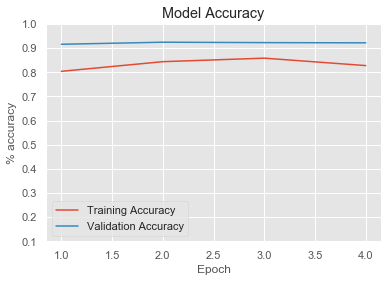

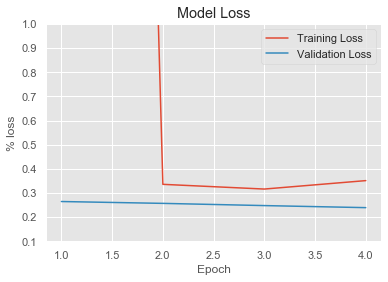

In [25]:
plt.style.use('ggplot')
plot_model_results(history_model_1)

In [26]:
results_model_0 = model_0.evaluate(test)

37/37 [==============================] - 32s 824ms/step - loss: 0.1990 - accuracy: 0.9164


In [27]:
results_model_1 = model_1.evaluate(test)

37/37 [==============================] - 141s 4s/step - loss: 0.2570 - accuracy: 0.9241


## `model_1` Results
- Interestingly, we didn't get as high of an accuracy score as we did with the initial model, `model_0`. 
- We still performed well here, with about 88% validation accuracy; but we did have considerable loss as well.

## Next Steps
- More aggresive data augmentation and/or dropout
- Use of L1 and L2 regularization (also known as "weight decay")
- Fine-tuning one more convolutional block (alongside greater regularization)
- `model_2`: Will try to add to `model_0` by adding another convolutional block or try to increase # of epochs

In [28]:
# the model outputs 3D feature maps (height, width, features)
model_2 = Sequential()
model_2.add(Conv2D(16, (3, 3), input_shape=(256, 256, 3)))
model_2.add(Activation('relu'))
model_2.add(MaxPooling2D(pool_size=(2, 2)))

# 2nd layer
model_2.add(Conv2D(32, (3, 3)))
model_2.add(Activation('relu'))
model_2.add(MaxPooling2D(pool_size=(2, 2)))

# 3rd layer
model_2.add(Conv2D(64, (3, 3)))
model_2.add(Activation('relu'))
model_2.add(MaxPooling2D(pool_size=(2, 2)))

# 4th layer
model_2.add(Conv2D(128, (3, 3)))
model_2.add(Activation('relu'))
model_2.add(MaxPooling2D(pool_size=(2, 2)))

# this converts the 3D feature maps to 1D feature vectors
model_2.add(Flatten())  
model_2.add(Dense(128))
model_2.add(Activation('relu'))
model_2.add(Dropout(0.5))
model_2.add(Dense(1))
model_2.add(Activation('sigmoid'))

# stop training when a monitored metric has stopped improving.
# goal of a training is to maximize accuracy (monitor)
# patience: # of epochs with no improvement after which training will be stopped (2)
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', 
                                                  mode= 'max', 
                                                  restore_best_weights=True, 
                                                  patience=2)

# compile the model
opt = tf.keras.optimizers.Adam(learning_rate= 0.001)
model_2.compile(loss='binary_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

# get the summary
model_2.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 254, 254, 16)      448       
_________________________________________________________________
activation_8 (Activation)    (None, 254, 254, 16)      0         
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 127, 127, 16)      0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 125, 125, 32)      4640      
_________________________________________________________________
activation_9 (Activation)    (None, 125, 125, 32)      0         
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 62, 62, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 60, 60, 64)       

In [29]:
# fit the model
history_model_2 = model_2.fit(train, epochs=5, validation_data=test, callbacks=early_stopping)

Epoch 1/5
147/147 [==============================] - 216s 1s/step - loss: 1.2961 - accuracy: 0.8333 - val_loss: 0.2093 - val_accuracy: 0.9300
Epoch 2/5
147/147 [==============================] - 205s 1s/step - loss: 0.2333 - accuracy: 0.9189 - val_loss: 0.1762 - val_accuracy: 0.9300
Epoch 3/5
147/147 [==============================] - 198s 1s/step - loss: 0.2059 - accuracy: 0.9266 - val_loss: 0.1841 - val_accuracy: 0.9334
Epoch 4/5
147/147 [==============================] - 198s 1s/step - loss: 0.1687 - accuracy: 0.9445 - val_loss: 0.1844 - val_accuracy: 0.9292
Epoch 5/5
147/147 [==============================] - 183s 1s/step - loss: 0.1636 - accuracy: 0.9434 - val_loss: 0.1586 - val_accuracy: 0.9437


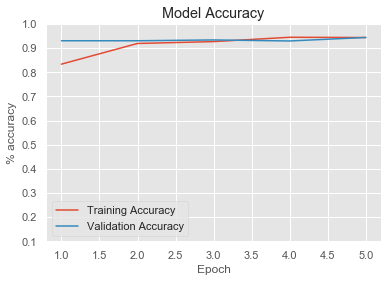

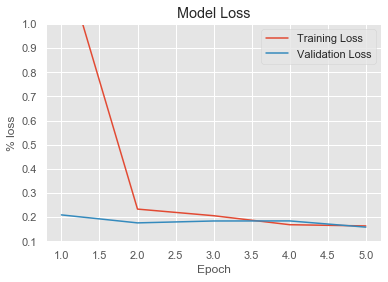

In [30]:
plt.style.use('ggplot')
plot_model_results(history_model_2)

In [31]:
results_model_2 = model_2.evaluate(test)

37/37 [==============================] - 16s 403ms/step - loss: 0.1586 - accuracy: 0.9437


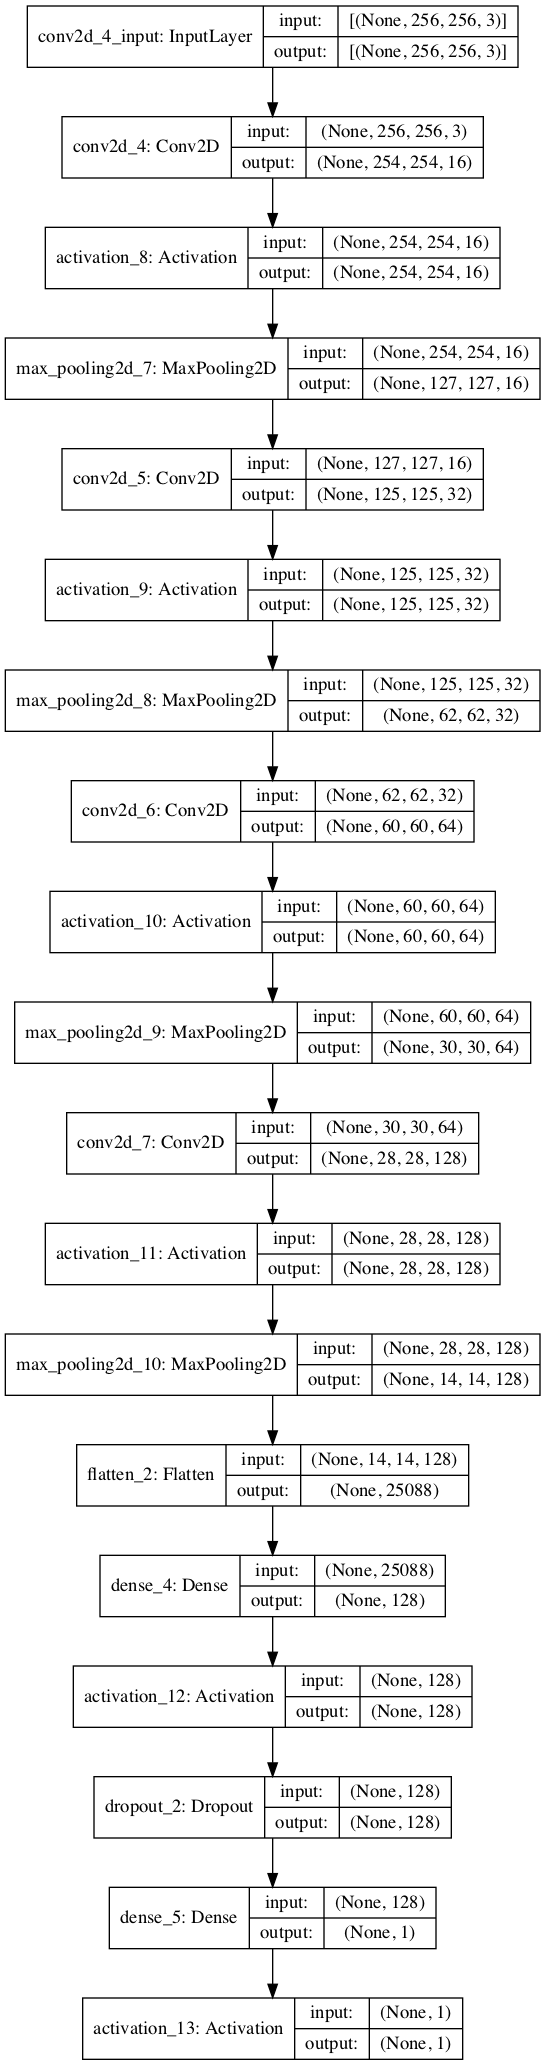

In [32]:
plot_model(model_2, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

## `model_2` Results and Conclusion
- Adding another layer to the initial model we started with actually did deliver on maximizing accuracy (93%) and minimizing loss (22%)
- It seems like adding another layer was necessary to improve the model in classifying images

## Future Steps
- Further tuning can be employed in the future:
    - Data augmentation in the preprocessing steps to mitigate the data imbalance
    - More dropout to help reduce overfitting
        - It prevents layers from seeing the same exact pattern twice
    - Add more epochs to model, because it showed that accuracy was slightly increasing, and loss was decreasing